<a href="https://colab.research.google.com/github/pipecode-br/deep_learning_pytorch/blob/main/architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Etapa 1: Importar biblioteca

In [104]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
torch.__version__

'1.10.0+cu111'

In [ ]:
torch.manual_seed(123)

### Etapa 2: Construir modelo

In [ ]:
class feature(nn.Module):
  def __init__(self) -> None:
      super().__init__()
      #primeiras camadas conv do yolo
      self.linear = nn.Linear(4,4)
  def forward(self,X):
    X = self.linear(X)
    return X

In [ ]:
class discriminator(nn.Module):
  def __init__(self) -> None:
      super().__init__()
      #flatter
      #reduz
      #ativador
  def forward(self,X1,X2):
    return X1

In [ ]:
class siamese(nn.Module):
  def __init__(self) -> None:
      super().__init__()
      self.feature = feature()
      self.discriminator = discriminator()
  def forward(self,X1,X2):
    X1 = self.feature(X1)
    X2 = self.feature(X2)
    X = self.discriminator(X1,X2)    
    return X

In [ ]:
net = siamese()
param = net.parameters()
print(net)
print(param)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(param)

siamese(
  (feature): feature(
    (flatten): Linear(in_features=4, out_features=4, bias=True)
  )
  (discriminator): discriminator()
)
<generator object Module.parameters at 0x7f64fbb526d0>


### Load Model Resnet

In [66]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()
print("Load model")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Load model


### Separa primeiras camadas

In [106]:
first_resnet = nn.Sequential(
          model.conv1,
          model.bn1,
          model.relu,
          model.maxpool
        )

In [107]:
from torchsummary import summary

summary(first_resnet, (3 , 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
Total params: 9,536
Trainable params: 9,536
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 6.50
Params size (MB): 0.04
Estimated Total Size (MB): 6.72
----------------------------------------------------------------


## Testa sub modelo em um exemplo real

In [62]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [98]:
# sample execution (requires torchvision)
from PIL import Image
import numpy as np
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [108]:
model1 = first_resnet
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model1.to('cuda')

with torch.no_grad():
    output = model1(input_batch)
    out1=output.cpu().numpy()
print(out1.shape)

(1, 64, 56, 56)


### concatena features da camada de saida

In [109]:
type(out1)
conv_unif = np.sum(out1[0],axis=0)/out1[0].shape[0]

### visualiza resultado

In [110]:
import matplotlib.pyplot as plt
plt.style.use('classic')

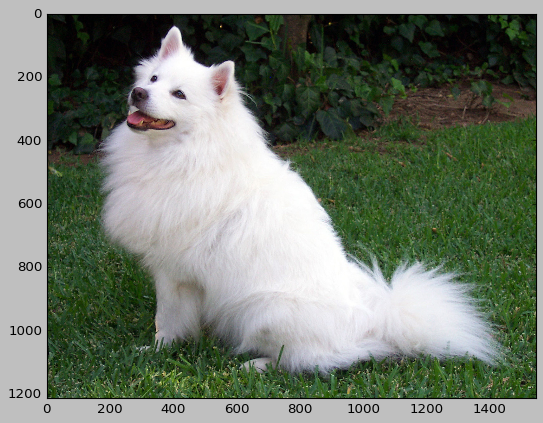

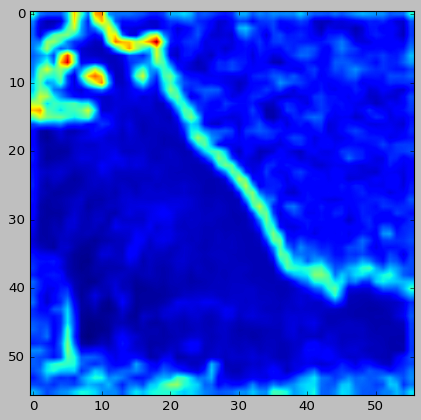

In [111]:
plt.imshow(input_image)
plt.show()
plt.imshow(conv_unif)
plt.show()
